# Exploratory Data Analysis - TripAdvisor data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
v
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
def freq_dict_generator(cuisine_list, cuisine_dict):
    """Creation of a dict containing all of the cuisine types. """
    for cuisine in cuisine_list:
        if cuisine not in cuisine_dict:
            cuisine_dict[cuisine] = 1
        else:
            cuisine_dict[cuisine] += 1

def col_evaluation(ls, col_name):
    """ Function used to check if a given cuisine is present in the list of the 'cuisine' column. It is
    used in a parallelised manner."""
    if col_name in ls:
        val = 1
    else:
        val = 0
    return val
            
def generate_cuisine_cols(df, cuisine_dict):
    """ Creation of the columns containing all of the cuisine types in a dataframe. """
    for col_name in cuisine_dict:
        df[col_name] = df['cuisine'].apply(lambda x: col_evaluation(x, col_name))
    return df


def score_builder(text):
    if text != 'Ranking not found':
        rank = int(text[1])
        total_entries = int(text.split()[2].replace(',',''))
        score = (total_entries - rank + 1) / total_entries
        return round(score, 3)
    else:
        return None
    
def town_extractor(text):
    if text != 'Ranking not found':
        return text.split()[-1]
    else:
        return None

def cleaning_pipeline(df):
    cuisine_dict = {}
    df_restaurants_cuisine = df.copy()
    
    # Creates a frequency dictionary containing the occurence of all types of cuisine
    df_restaurants_cuisine['cuisine'].apply(lambda x: freq_dict_generator(x, cuisine_dict))
    
    # Converting reviews as int
    df_restaurants_cuisine['nb_reviews'] = df_restaurants_cuisine['nb_reviews'].str.replace(',','').astype('int64')
    
    # Creates a ranking score in order to compare restaurants competing among a different amount of restaurants
    # in a town. The score of the restaurant ranked i among n restaurants is as such : 
    # Score = (n - i + 1) / n
    df_restaurants_cuisine['score'] = df_restaurants_cuisine['ranking'].apply(lambda x: score_builder(x))
    
    # Extracts the town where the restaurant is located
    df_restaurants_cuisine['town'] = df_restaurants_cuisine['ranking'].apply(lambda x: town_extractor(x))
    
    # Used to generate the columns indicating the cuisine of the restaurant
    df_restaurants_cuisine = generate_cuisine_cols(df_restaurants_cuisine, cuisine_dict)
    
    return df_restaurants_cuisine

def cuisine_stats(cuisine_name, df, cols=['nb_reviews', 'min_price', 'max_price', 'rating', 'score', 'town']):
    cols = [cuisine_name] + cols
    df_res = df[cols].groupby(by=cuisine_name).mean()
    return df_res

In [4]:
root_path = os.path.join('../../', 'scraper', 'scraped_data')

restaurants_path = os.path.join(root_path, 'restaurants.json')
review_path = os.path.join(root_path, 'reviews.json')
users_path = os.path.join(root_path, 'users.json')

df_restaurants = pd.read_json(restaurants_path, lines=True)
restaurants = list(df_restaurants['restaurant_id'])
df_restaurants = df_restaurants.set_index('restaurant_id')

df_reviews = pd.read_json(review_path, lines=True)
df_users = pd.read_json(users_path, lines=True)


In [5]:
df_restaurants_cuisine = cleaning_pipeline(df_restaurants)

## Visualisation of a restaurant's reviews

In [6]:
restaurant_id = "0"
while (restaurant_id not in restaurants):
    try:
        restaurant_id = int(input("Enter restaurant id from 1 to 143 : "))
    except:
        print("Please enter int")

Enter restaurant id from 1 to 143 : 5


### TF-IDF matrix

In [7]:
target_csv = str(restaurant_id) + '_word_freq.csv'
target_csv_path = os.path.join('..', 'cleaned_data', 'restaurant_word_frequencies', target_csv)

df_tfidf = pd.read_csv(target_csv_path, index_col=['Unnamed: 0'])

In [8]:
df_tfidf.head()

,10,150,18,20,2nd,30,30pm,35,40,43,4th,51,60,able,absolute,absolutely,accommodate,accompany,accpommodating,actually,add,addition,advance,affordable,africa,ago,agree,ahead,amaze,amazing,amazingly,ambiance,ambience,amorossa,anari,andrea,andreas,aniri,aniseed,anniversary,apparently,appetiser,area,arm,array,arrive,artichoke,artistic,ask,ate,atmosphere,attention,attentive,aubergine,authentic,authentically,available,average,await,away,awesome,background,bag,bake,baklava,balance,ball,banana,bang,bar,bass,batter,bean,beat,beautiful,beautifully,beef,beer,beetroot,begin,believe,best,big,bijou,birthday,bit,bite,blow,book,bottle,bravo,bread,breadcrumb,bream,brilliant,brilliantly,bring,broccoli,brother,brownie,bud,bunch,buzz,cake,calamari,calamary,candied,candy,carafe,card,care,caribbean,carrot,catering,cauliflower,celebrate,certainly,chance,change,chap,chardonnay,charge,charm,charming,chat,cheap,check,cheese,cheesecake,chef,cherry,chic,chicken,chili,chill,chilly,chip,chiswick,chocolate,choice,choose,chop,claim,class,classic,clean,clear,clearly,close,code,collection,combination,combine,come,complain,complaint,complement,complete,compliment,complimentary,compote,compromise,confident,container,contemporary,continue,conversation,cook,cooking,copious,cost,cosy,couple,courgette,courgettes,course,courteous,cow,creates,creation,creative,crisp,crispy,crostini,cuisine,cusine,customer,cutlet,cypriot,cyprus,dad,daily,date,daughter,day,decide,decoration,dedicate,definitely,definitley,delay,delectable,deli,delicious,delight,delighted,delightful,deliver,desert,deserve,design,despite,dessert,detract,devour,dgoing,die,diet,different,diffrence,diminish,din,diner,dining,dinner,dip,direct,disappoint,disappointed,disappointment,discovery,dish,display,distinctively,divine,doggie,door,doorstep,doubt,draw,drink,drinkable,drizzle,drop,dry,dull,early,easily,east,eastern,easy,eat,eater,eating,efficient,elect,encourage,end,endear,engage,enjoy,enthusiasm,enthusiastic,environment,equally,especially,establishment,evening,example,exceed,excellent,exceptional,excite,exciting,execution,expectation,experience,expertly,explain,exquisite,exquisitely,extend,extensive,extra,extremely,eye,fab,fabulous,fact,fair,familiar,family,fantastic,far,fasolaki,father,fault,favourite,feast,february,feed,feel,fell,felt,feta,filleted,final,finally,financee,fine,firstly,fish,flair,flat,flavour,flavoured,flavoursome,flexibility,flourish,flower,fluffy,focus,follow,food,foodie,footpath,form,forward,free,freebie,fresh,freshly,friday,fried,friend,friendly,fritter,fusion,garden,garlic,gem,general,generous,generously,genuine,genuinely,gesture,gigantic,gimmicky,girlfriend,glad,glass,glaze,glow,glowing,gluten,good,goodie,goody,grand,grandson,great,greece,greek,greet,grill,grilled,group,guarantee,guess,guest,guide,half,halloumi,haloumi,ham,hammersmith,hand,happen,happy,hard,haweli,head,healthy,hear,heart,heaven,help,helpful,heritage,hesitate,hesitation,hidden,high,highlight,highly,hint,home,homemade,honestly,honey,hope,hospitality,host,hotel,houmous,house,htere,huge,hummus,idea,imagine,immediately,impeccable,impress,impressed,improve,improvement,ina,include,incredible,incredibly,indication,individually,influence,informal,informative,ingredient,initially,inn,innovative,inside,inspirational,inspire,instantly,instead,interesting,interior,intimate,intrusive,invitation,involve,island,item,jazz,jelly,job,joy,juice,juicy,jumbo,kalamari,kebabs,keen,keo,key,kick,kid,kind,king,kitchen,know,lamb,lamp,land,large,lead,leave,leftover,lemon,lemonade,let,level,light,like,lime,limit,limited,list,litlle,little,live,local,lock,lockdown,london,long,look,lot,love,lovely,lover,low,luck,lucky,lunch,mackerel,mad,main,maintain,make,making,man,manage,mandarin,mandarinade,manner,marinate,mark,markedly,marry,match,maximise,maybe,meal,meat,med,meditarrean,mediterranean,meeting,mention,menu,meze,mezes,mezze,middle,milk,mind,mineral,mint,miss,mistake,mix,mixed,modern,monster,month,mountain,mouse,mouth,mum,mushroom,music,myriad,mytho

In [9]:
df_tfidf_mean = df_tfidf.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
df_tfidf_mean.head()

,tfidf mean
food,0.070914
restaurant,0.051776
service,0.048836
great,0.047972
delicious,0.043585


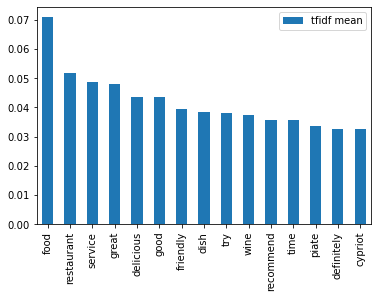

In [10]:
df_tfidf_mean[:15].plot(kind='bar')
plt.show()

### Wordcloud visualisation

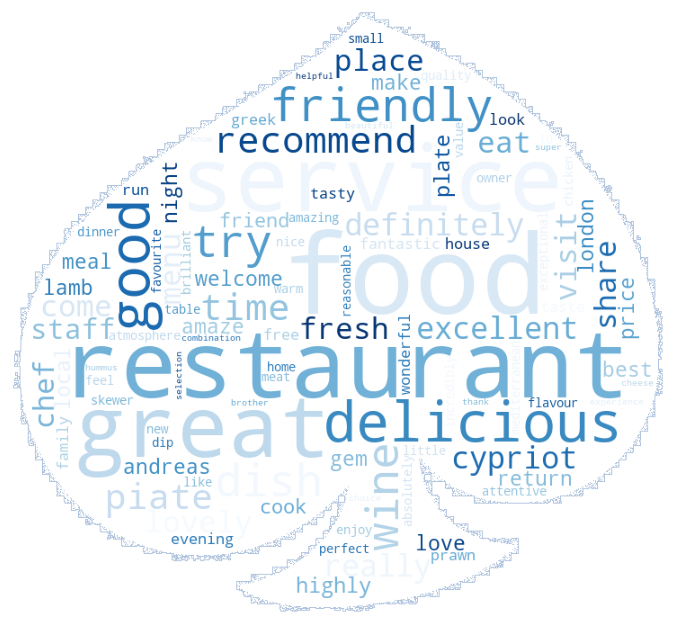

In [11]:
target_img = str(restaurant_id) + '_word_cloud.png'
target_img_path = os.path.join('..', 'cleaned_data', 'restaurant_wordclouds', target_img)
img = plt.imread(target_img_path)

plt.figure(figsize=(12,16))
plt.imshow(img)
plt.axis("off")
plt.show()

Other wordclouds and TF-IDF can be found in the dedicated folder

# Global restaurant analysis

In [12]:
df_restaurants_cuisine.head()

,name,nb_reviews,min_price,max_price,cuisine,address,phone_number,website,menu,ranking,rating,score,town,Italian,Pizza,Mediterranean,Indian,Asian,Pakistani,Vegetarian Friendly,International,European,British,Grill,Afghani,Vegan Options,Cafe,Japanese,French,Sushi,Fast food,Lebanese,Contemporary,Steakhouse,Argentinian,Deli,African,Moroccan,Balti,Chinese,Turkish,Seafood,Tuscan,Central-Italian,Neapolitan,Middle Eastern,Bar,Pub,Spanish,Thai,Fusion,Vietnamese,Barbecue,American,Cantonese,Malaysian,Sri Lankan,Street Food,Tibetan,Persian,Nepalese,Hong Kong,Gluten Free Options,Latin,Healthy
restaurant_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,La Dolce Vita,1118,2,3,"[Italian, Pizza, Mediterranean]","195 Waldegrave Road, Teddington, Richmond TW11...",+44 20 8977 8779,Website not scraped,Menu not scraped,#1 of 51 Restaurants in Teddington,5.0,1.000,Teddington,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Giftos Lahore Karahi,647,2,3,"[Indian, Asian, Pakistani]","162-164 The Broadway, Southall, Ealing UB1 1NN...",+44 20 8813 8669,Website not scraped,Menu not scraped,Ranking not found,4.0,NaN,None,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Orpington Citi Kitchen,139,2,3,"[Indian, Asian, Vegetarian Friendly]","82 Cotmandene Crescent, Orpington, Bromley BR5...",+44 20 8302 2222,Website not scraped,Menu not scraped,#2 of 120 Restaurants in Orpington,5.0,0.992,Orpington,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,the Orpington,173,2,3,"[International, European, British]","161 High Street Next door to Iceland, Orpingto...",+44 1689 666900,Website not scraped,Menu not scraped,#1 of 120 Restaurants in Orpington,5.0,1.000,Orpington,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bombaylicious,74,2,3,"[Indian, Asian, Grill]","145 Brighton Road, Coulsdon CR5 2NJ England",+44 20 8660 8915,Website not scraped,Menu not scraped,Ranking not found,5.0,NaN,None,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
df_restaurants_cuisine = df_restaurants_cuisine.set_index('min_price')

In [18]:
df_restaurants_cuisine.head()

,name,nb_reviews,max_price,cuisine,address,phone_number,website,menu,ranking,rating,score,town,Italian,Pizza,Mediterranean,Indian,Asian,Pakistani,Vegetarian Friendly,International,European,British,Grill,Afghani,Vegan Options,Cafe,Japanese,French,Sushi,Fast food,Lebanese,Contemporary,Steakhouse,Argentinian,Deli,African,Moroccan,Balti,Chinese,Turkish,Seafood,Tuscan,Central-Italian,Neapolitan,Middle Eastern,Bar,Pub,Spanish,Thai,Fusion,Vietnamese,Barbecue,American,Cantonese,Malaysian,Sri Lankan,Street Food,Tibetan,Persian,Nepalese,Hong Kong,Gluten Free Options,Latin,Healthy
min_price,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,La Dolce Vita,1118,3,"[Italian, Pizza, Mediterranean]","195 Waldegrave Road, Teddington, Richmond TW11...",+44 20 8977 8779,Website not scraped,Menu not scraped,#1 of 51 Restaurants in Teddington,5.0,1.000,Teddington,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Giftos Lahore Karahi,647,3,"[Indian, Asian, Pakistani]","162-164 The Broadway, Southall, Ealing UB1 1NN...",+44 20 8813 8669,Website not scraped,Menu not scraped,Ranking not found,4.0,NaN,None,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Orpington Citi Kitchen,139,3,"[Indian, Asian, Vegetarian Friendly]","82 Cotmandene Crescent, Orpington, Bromley BR5...",+44 20 8302 2222,Website not scraped,Menu not scraped,#2 of 120 Restaurants in Orpington,5.0,0.992,Orpington,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,the Orpington,173,3,"[International, European, British]","161 High Street Next door to Iceland, Orpingto...",+44 1689 666900,Website not scraped,Menu not scraped,#1 of 120 Restaurants in Orpington,5.0,1.000,Orpington,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bombaylicious,74,3,"[Indian, Asian, Grill]","145 Brighton Road, Coulsdon CR5 2NJ England",+44 20 8660 8915,Website not scraped,Menu not scraped,Ranking not found,5.0,NaN,None,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
df_pizzeria = cuisine_stats('Pizza', df_restaurants_cuisine)
df_pizzeria.head()

,nb_reviews,min_price,max_price,rating,score
Pizza,,,,,
0,456.242718,2.067961,2.902913,4.631068,0.990722
1,480.380952,1.952381,2.904762,4.619048,0.986222


In [14]:
df_vegan = cuisine_stats('Vegan Options', df_restaurants_cuisine)
df_vegan.head()

,nb_reviews,min_price,max_price,rating,score
Vegan Options,,,,,
0,464.452174,2.078261,2.947826,4.626087,0.990376
1,407.666667,1.666667,2.333333,4.666667,0.984143


In [16]:
df_restaurants_cuisine.groupby(by='rating').count()['name']

rating
3.5     1
4.0     2
4.5    85
5.0    36
Name: name, dtype: int64